In [97]:
# User "Lukas" oder "Daniel" festlegen
User = "Daniel"

if User == "Daniel":
 from google.colab import drive
 drive.mount('/content/drive')
 DATA_PATH = "/content/drive/Othercomputers/My MacBook Pro/github/ArtXFashion/neural_content_style_transfer/data"
 gpu = !nvidia-smi -L
 print(gpu[0])

if User == "Lukas":
  DATA_PATH = "data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


# Neural Content Style Transfer


Basiert auf (1) https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf and (2) https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer.

In diesem Notebook wird der klassische Neural Style Transfer (NST) zu Neural Content Style Transfer (NCST) erweitert.








In [98]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import torch.nn

# Load in the pre-trained VGG

Die Feautre Maps des vortrainierten 19-schichtigen VGG Netzwerks werden betrachtet. Im unteren Bild sieht man, dass die Convolution Schichten nach ihrem Stack und ihrer Reinfolge in dem Stack benannt sind. Conv_5_4 bedeutet in dem 5ten Stack die 4te Schicht und damit die letzte Convolution Schicht.

<img src='https://github.com/danielpuhl/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />


In [99]:
# laden der Feature Extraktion Schichten des VGG19, den Klassifizier Part benötigen wir nicht
vgg = models.vgg19(pretrained=True).features

# alle VGG Parameter werden eingefroren, da wir nicht trainieren wollen
for param in vgg.parameters():
    param.requires_grad_(False)

In [100]:
# Model auf die GPU umziehen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#Laden des Fashion Bildes und des Art Bildes

Mit Hilfe des load_image Funktion können Bilder beliebiger Größe geladen werden.
Übernommen aus (2)

In [101]:
def load_image(img_path, max_size=400, shape=None):
    ''' Laden und transformieren von Bildern und Sicherstellung dass das Bild <= 400 pixels in der x-y dimension.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # große Bilder beeinträchtigen die Ausführungszeit
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      ])

    # entfernen des transparenten alpha channels (:3) und hinzufügen der batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [102]:
# Hilfsfunktion um ein Tensor Bild wieder darzustellen (un-normalizing, konvertieren des Tensors in ein NumPy Bild), entnommen aus (2)
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [103]:
def in_transform(image):
    in_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      ])

    # entfernen des transparenten alpha channels (:3) und hinzufügen der batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

### Bilder laden

In [104]:
# laden des fashion und des art bildes und selbe Größe setzen
# das fashion bild ist hier der Einfachheit halber ein weißer Canvas bzw. ein weißer Canvas mit den Kontouren des Art Bildes
fashion_image = load_image(os.path.join(DATA_PATH,"images_fashion/0744.jpg")) # to(device) rausgenommen
fashion_mask = np.asarray(transforms.Resize(fashion_image.shape[2:])(Image.open(os.path.join(DATA_PATH,"images_tshirt_masks/0744.png"))).convert("RGB"), dtype=float).clip(0, 1)
selected_clothing = im_convert(fashion_image) * fashion_mask 

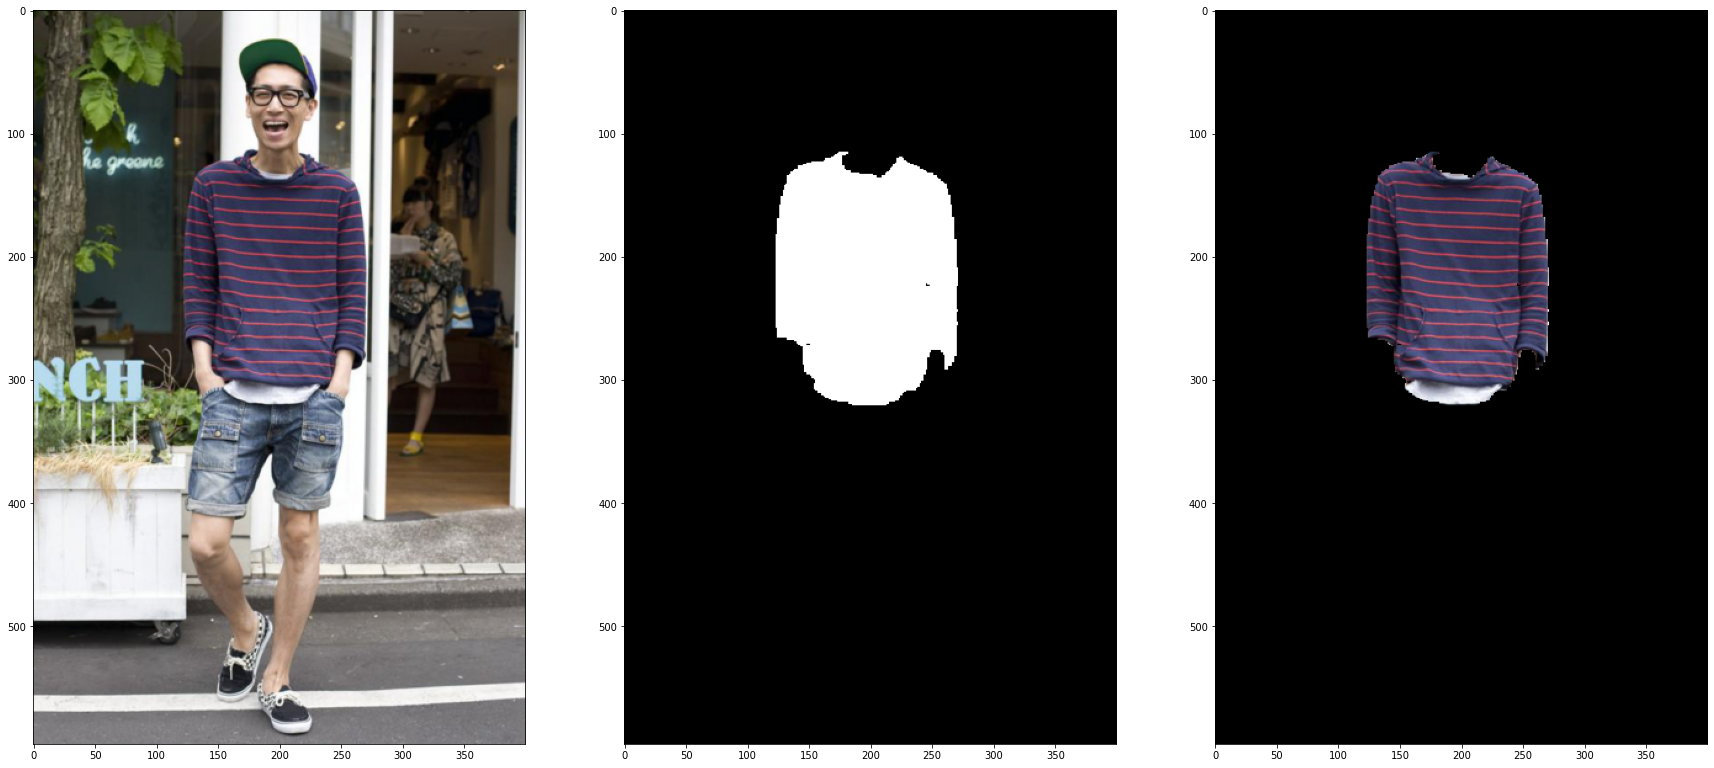

In [105]:
# Bilder anzeigen
# fashion Bild und art Bild nebeneinander
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))

# content and style imgbs side-by-side
ax1.imshow(im_convert(fashion_image)) #später kann man mal die Load Funktion anpassen, dass man auswählen kann ob man ein Tensor oder eine Numpy Bild haben möchte, ersparrt im_convert die ganze Zeit
ax2.imshow(fashion_mask)
ax3.imshow(selected_clothing)

0. Get minimum bounding rectangle (mbr) of clothing

In [106]:
# Detecting rgb value of the background, mistakes could be avoided by comparing the rgb values of all corners
x_first_pixel_fashion = None
y_first_pixel_fashion = None


for row in range(fashion_mask.shape[0]):
  rgb_values_row = fashion_mask[row,:]
  if rgb_values_row.sum() >= 2.9 : # white pixel has a sum of RGB values of 3, 2.9 is chosen because of some tolerance issues
    y_first_pixel_fashion = row
    break
 
for row in range(fashion_mask.shape[0])[y_first_pixel_fashion:]:
  rgb_values_row = fashion_mask[row,:]
  if rgb_values_row.sum() <= 2.9: 
    y_last_pixel_fashion = row-1
    break

for col in range(fashion_mask.shape[1]):
  rgb_values_col = fashion_mask[:,col]
  if rgb_values_col.sum() >= 2.9 :
    x_first_pixel_fashion = col
    break

for col in range(fashion_mask.shape[1])[x_first_pixel_fashion:]:
  rgb_values_col = fashion_mask[:,col]
  if rgb_values_col.sum() <= 2.9:
    x_last_pixel_fashion = col-1
    break

# incorporate some confirmation method for real world practice eg. sum has to be over 3 iteration over the defined treshhold

# clockwise pixel position definition of the corners of the smallest rectangle which encompasses the fashion item
# (topleft, topright, bottomright, bottomleft)
white_rectangle_size_pixel_position = [
  [y_first_pixel_fashion,x_first_pixel_fashion],
  [y_first_pixel_fashion,x_last_pixel_fashion],
  [y_last_pixel_fashion,x_last_pixel_fashion],
  [y_last_pixel_fashion,x_first_pixel_fashion]
]
white_rectangle_size_pixel_position

[[115, 123], [115, 270], [320, 270], [320, 123]]

1. Creating a white image with dimension that can be calculated from white_rectangle_size_pixel_position values -> called w_i_ncts

In [107]:
mbr_shape = (y_last_pixel_fashion - y_first_pixel_fashion, x_last_pixel_fashion - x_first_pixel_fashion, 3)
w_i_ncts = np.zeros(mbr_shape, dtype=np.uint8)
w_i_ncts[:, :] = [255, 255, 255]
w_i_ncts.shape

(205, 147, 3)

2. w_i_ncts is basically the fashion_image for conducting NCTS. -> meaning fashion_image = load_image(w_incts) (pseudocode for the load_image function above)

In [108]:
mbr_location = np.s_[y_first_pixel_fashion:y_last_pixel_fashion,x_first_pixel_fashion:x_last_pixel_fashion,:]
cropped_fashion_mask = fashion_mask[mbr_location]
cropped_selected_clothing = selected_clothing[mbr_location]

In [109]:
art_image = load_image(os.path.join(DATA_PATH,"images_art/Katze.png"), shape=mbr_shape[:2]) # to(device) rausgenommen, später ein Block wo alle nötigen Images to(device) genommen werden

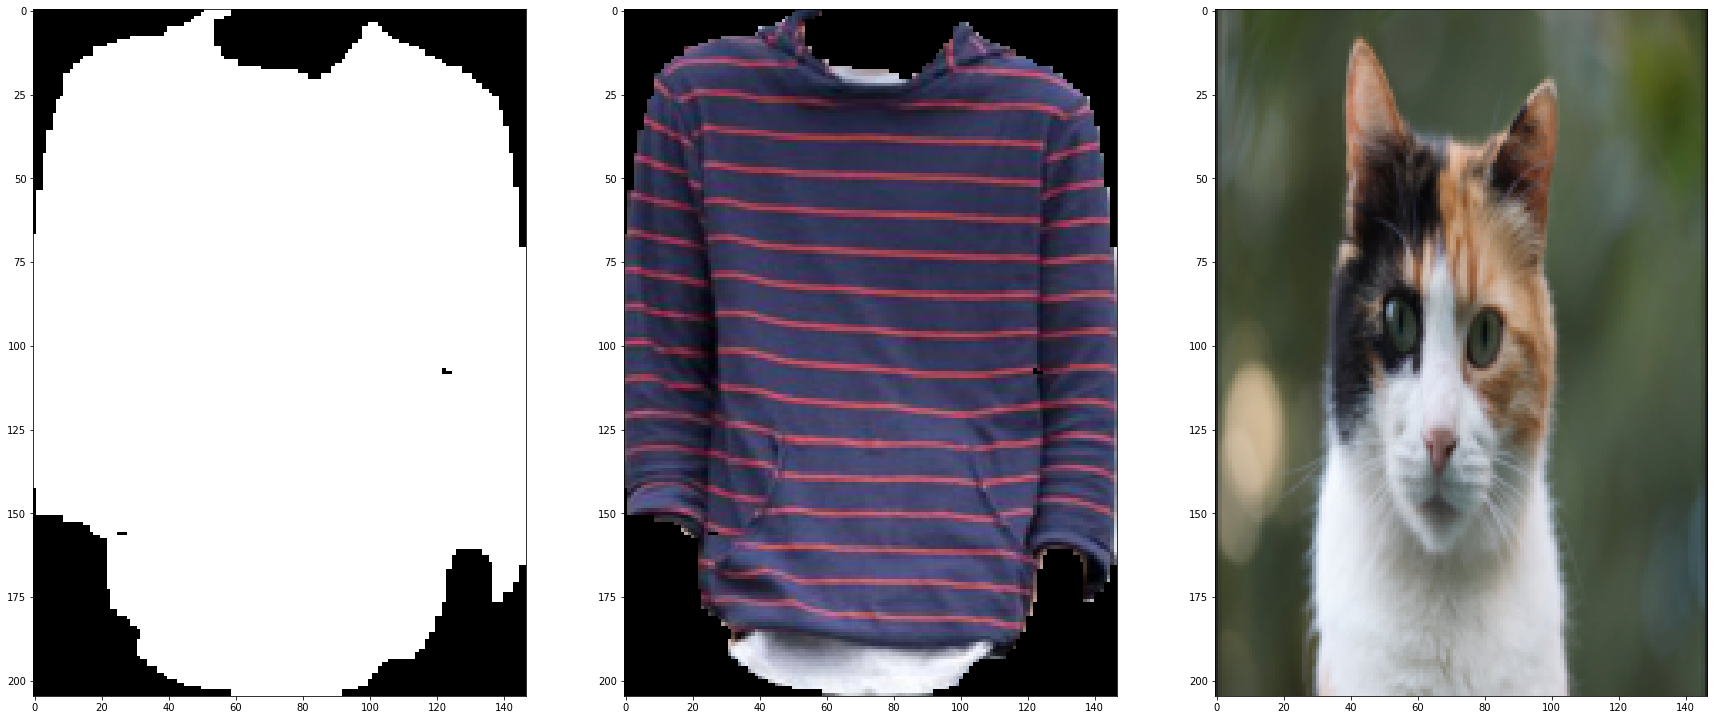

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))

ax1.imshow(cropped_fashion_mask)
ax2.imshow(cropped_selected_clothing)
ax3.imshow(im_convert(art_image))

# Hyperparameter Festlegen


## 1. Auswahl und Gewichtung der Schichten für die Stlye Repräsentation
Auswahl:
- Layer die in Paper (1) betrachtet werden: 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'
- Layer 'Conv4_2' wird wie im Paper als content layer gewählt. Im Paper wird diese für die Berechnung des Style losses entfernt, wir behalten sie drin um noch mehr den Content des Art Bildes rauszustellen
- Erweitern der betrachteten Layer führt schnell zu einem Memory Overflow ca. 14 GB

Gewichtung:
- Für jede der Schichten für die Berechnung des Style Losses können Gewichte festgelegt werden
- Hohe Gewichtung der früheren Schichten sorgt für größere Style Artefakte, Hohe Gewichtung der späteren Schichten sorgt für kleinere Style Artefakte




In [111]:
# Auswahl der Schichten und der Gewichte
# Content Layer mal rausgenommen 'conv4_2':0.2,
style_layers_and_style_weights = {'conv1_1':1.,'conv2_1':0.75, 'conv3_1':0.2, 'conv4_1':0.2,'conv5_1':0.2}

# Auwahl der Content Layer
content_layer = 'conv4_2'

style_layers = list(style_layers_and_style_weights.keys())
selected_layers = style_layers.__add__([content_layer])

## 2. Gewichtung des Verhältnisses zwischen Style und Content auf dem tranformierten Fashion Bild

Auf Basis des Paper (1) und angepasst an unseren Neural Content Style Ansatz definieren wir Alphas (`content_fashion_weight` und 'content_art_weight') und ein Beta (`style_art_weight`). Dieses Verhältnis beeinflusst, wie _stylisiert_ Ihr endgültiges Bild ist. Es wird empfohlen, den Wert für "content_fashion_
weight" = 1 zu belassen und "style_weight" so einzustellen, dass das gewünschte Verhältnis erreicht wird.

In [112]:
# Festlegung der alphas und des beta
content_fashion_weight = 0.5  # alpha_fashion
content_art_weight = 10 #alpha_art
style_art_weight = 1e6  # beta

## 3. Anzahl der Optimierungs-/Iterationsschritte auf dem transformed_fashion_image
Mindestens 2000 nach Gefühl, umso mehr umso besser

In [113]:
#Festlegen der Optimierungsschritte
steps = 500

## 4. Learning Rate des Optimizers


In [114]:
learning_rate = 0.03

# Content und Style Features


In [115]:
# Convolutional Layer und ihr Name in der VGG Definition
dict_layers_name_to_num = {'conv1_1':'0',
                'conv1_2':'2',
                'conv2_1':'5', 
                'conv2_2':'7', 
                'conv3_1':'10', 
                'conv3_2':'12',
                'conv3_3':'14',
                'conv3_4':'16',
                'conv4_1':'19',
                'conv4_2':'21',
                'conv4_3':'23',
                'conv4_4':'25',
                'conv5_1':'28',
                'conv5_2':'30',
                'conv5_3':'32',
                'conv5_4':'34'}
dict_layers_num_to_name = {v: k for k, v in dict_layers_name_to_num.items()}

selected_layers_num = [dict_layers_name_to_num[layer] for layer in selected_layers]

In [116]:
# Methode um die Feature Maps einer spezifizierten Schicht auszugegeben
# basiert auf(2)
# ggf. ein paar Schichten rauslassen um den GPU Speicher nicht auszureizen


def get_features(image, model, selected_layers):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """             
         
        
    features = {}
    x = image

    # model._modules ist ein dictionary in dem jede Schicht des Models gelistet ist
    for name, layer in model._modules.items():
        x = layer(x)
        if name in selected_layers_num:
            features[dict_layers_num_to_name[name]] = x
        
            
    return features

---
## Gram Matrix (siehe (2))


The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 



In [117]:
#Funktion zur Berechnung der Gram Matrix aus (2) entnommen
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

# Feautres des Art und des Fashion Bildes extrahieren

In [119]:
# relevante Bilder in Tensoren umwandeln und auf GPU übertragen
art_image.to(device)
cropped_selected_clothing = in_transform(cropped_selected_clothing).float().to(device)

# Feature Maps des Art und des Fashion Bildes speichern
art_image_features = get_features(art_image, vgg, selected_layers)
fashion_image_features = get_features(cropped_selected_clothing, vgg, selected_layers)

# Gram Matrizen für jede Schicht bei Input des Art Bildes berechnen
style_grams = {layer: gram_matrix(art_image_features[layer]) for layer in art_image_features}

# Erstellung unseres target transformed_fashion_image welches iterativ basierend auf dem fashion_image transformiert wird
transformed_clothing = in_transform(cropped_fashion_mask).clone().float().requires_grad_(True).to(device)

# Durchfürung der Optimierung

3. Transforming w_i_ncts with NCTS

Total loss:  85702928.0


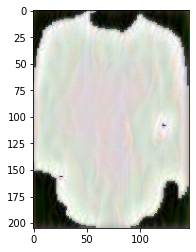

Total loss:  29486648.0


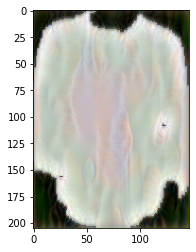

In [ ]:
# transformed_fashion_image alle "show_every" Schritte anzeigen
show_every = 100


optimizer = optim.Adam([transformed_clothing], lr=learning_rate)


for ii in range(1, steps+1):
    
    
    transformed_fashion_image_features = get_features(transformed_clothing, vgg, selected_layers)
    
    #content_fashion loss
    content_fashion_loss = torch.mean((transformed_fashion_image_features[content_layer] - fashion_image_features[content_layer])**2)


    # content_art loss
    content_art_loss = torch.mean((transformed_fashion_image_features[content_layer] - art_image_features[content_layer])**2)
    
    # style loss
    # mit 0 initialisieren
    style_loss = 0
    # für jede Schicht den loss der jeweiligen Gram Matrix daraufrechnen
    for layer in style_layers_and_style_weights:
  
        transformed_fashion_image_feature = transformed_fashion_image_features[layer]
        transformed_fashion_image_gram = gram_matrix(transformed_fashion_image_feature)
        _, d, h, w = transformed_clothing.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_layers_and_style_weights[layer] * torch.mean(( transformed_fashion_image_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    
    total_loss = content_art_weight * content_art_loss + style_art_weight * style_loss + content_fashion_weight * content_fashion_loss
    
    # updaten des transformed_fashion_image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(transformed_clothing))
        plt.show()

## Display the Target Image

4. Creating a blank image with the same shape as the original fashion_image/fashion_mask (widht and heigts) and locating w_i_ncts with the white_rectangle_size_pixel_positions in the blank image (see illustration below) -> it is called b_i_ncts in the illustration
 (How the rest of the image which is not w_i_ncts looks like does not matter, because in the next step this b_i_ncts is multiplied with the fashion_mask anyway)

 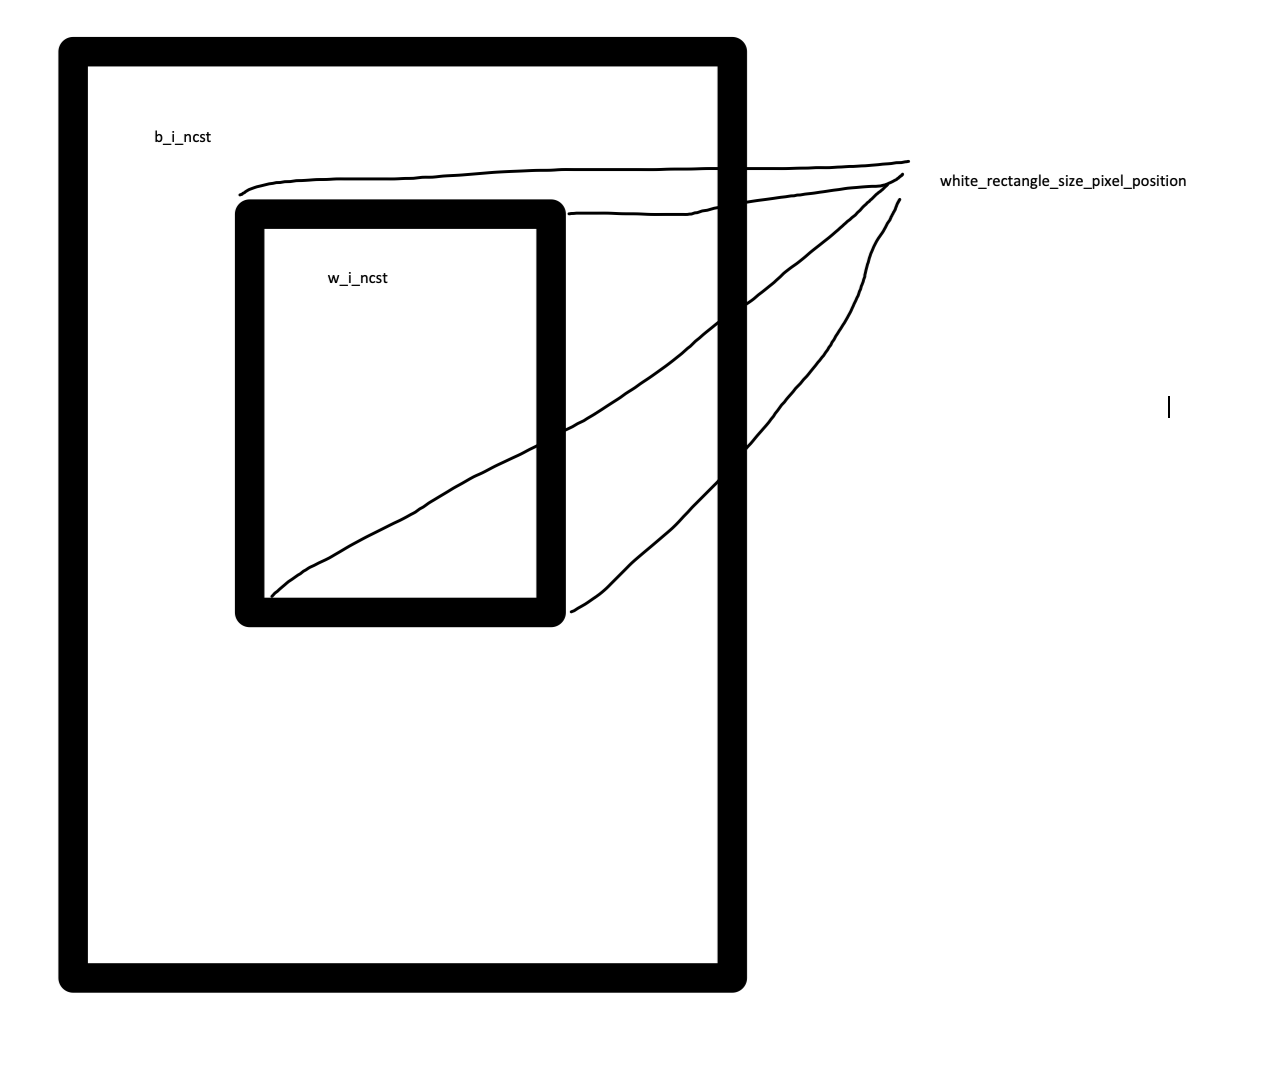

In [ ]:
b_i_ncts = np.zeros(im_convert(fashion_image).shape)
b_i_ncts[y_first_pixel_fashion:y_last_pixel_fashion,x_first_pixel_fashion:x_last_pixel_fashion,:] = im_convert(transformed_clothing) * cropped_fashion_mask

5. Multiply b_i_ncts witch original fashion image to get result

In [ ]:
transformed_fashion_image = im_convert(fashion_image) * b_i_ncts

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
ax1.imshow(im_convert(fashion_image))
ax2.imshow(im_convert(art_image))
ax3.imshow(im_convert(transformed_clothing))
ax4.imshow(b_i_ncts)

In [ ]:
result = im_convert(fashion_image)
result[b_i_ncts > 0] = b_i_ncts[b_i_ncts > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(fashion_image))
ax2.imshow(result)